### **Load the Data**

In [1]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

In [ ]:
import pandas as pd

df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')

### **Model Comparison**

**Instructions**: Run at least 2 different classification models. The classification models we have learned in class are: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html). For each model, try at least 2 different hyperparameter settings.

Then, make one or more visualizations that let you compare the models you trained. Sample visualizations you can make include confusion matrices, or graphs of train and validation accuracy/error. See past section and homework code for how to make these visualizations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## **Data Cleaning & Feature Engineering**

In [ ]:
target = "certified"
features = ['viewed','explored','nevents','ndays_act','nplay_video','nchapters','nforum_posts','education',
            'male','female','other','interacted', 'duration',
            'cs','cb','er','ph1','ph2']
missing = ['ndays_act','nplay_video','nchapters','duration'] # features that require imputation & scaling

In [ ]:
# fill in missing values
df_train['nevents'] = df_train['nevents'].fillna(0)
df_test['nevents'] = df_test['nevents'].fillna(0)


df_train['gender'] = df_train['gender'].fillna('o')
df_test['gender'] = df_test['gender'].fillna('o')

df_train['LoE_DI'] = df_train['LoE_DI'].fillna('Missing')
df_test['LoE_DI'] = df_test['LoE_DI'].fillna('Missing')

In [ ]:
# create new column called 'education' with categorical encoding of 'LoE_DI'
encoding_map = {'Missing': 0, 'Less than Secondary': 1, 'Secondary': 2, 'Bachelor\'s': 3, 'Master\'s' : 4, 'Doctorate' : 5}
df_train['education'] = df_train['LoE_DI'].replace(encoding_map)
df_test['education'] = df_test['LoE_DI'].replace(encoding_map)

In [ ]:
# create new feature 'interacted'
def fill_interacted(df):
  for index, row in df.iterrows():
    if df.loc[index, 'nevents'] == 0:
      df.loc[index, missing] = 0
      df.loc[index, 'interacted'] = 0
    else:
      df.loc[index, 'interacted'] = 1

# one-hot-encoding for gender
def one_hot_gender(df):
  for index, row in df.iterrows():
    if df.loc[index, 'gender'] == 'm':
      df.loc[index, 'male'] = 1
      df.loc[index, 'female'] = 0
      df.loc[index, 'other'] = 0
    elif df.loc[index, 'gender'] == 'f':
      df.loc[index, 'male'] = 0
      df.loc[index, 'female'] = 1
      df.loc[index, 'other'] = 0
    else:
      df.loc[index, 'male'] = 0
      df.loc[index, 'female'] = 0
      df.loc[index, 'other'] = 1

# impute values using mean of column
def fill_missing(df, scaler_means):
  for index, row in df.iterrows():
    if pd.isna(row['ndays_act']):
      df.loc[index, 'ndays_act'] = scaler_means[0]
    if pd.isna(row['nplay_video']):
      df.loc[index, 'nplay_video'] = scaler_means[1]
    if pd.isna(row['nchapters']):
      df.loc[index, 'nchapters'] = scaler_means[2]

# create new feature 'duration'
def fill_duration(df):
  for index, row in df.iterrows():
    if pd.isna(row['last_event_DI']):
      df.loc[index, 'duration'] = 0
    else:
      start = datetime.strptime(row['start_time_DI'], '%x').date()
      end = datetime.strptime(row['last_event_DI'], '%x').date()
      df.loc[index, 'duration'] = (end-start).days

# one-hot encoding for course_id
def one_hot_class(df):
  for index, row in df.iterrows():
    course = df.loc[index, 'course_id'][9:13]
    if course == 'CS50':
      df.loc[index, 'cs'] = 1
      df.loc[index, 'cb'] = 0
      df.loc[index, 'er'] = 0
      df.loc[index, 'ph1'] = 0
      df.loc[index, 'ph2'] = 0
    elif course == 'CB22':
      df.loc[index, 'cs'] = 0
      df.loc[index, 'cb'] = 1
      df.loc[index, 'er'] = 0
      df.loc[index, 'ph1'] = 0
      df.loc[index, 'ph2'] = 0
    elif course == 'ER22':
      df.loc[index, 'cs'] = 0
      df.loc[index, 'cb'] = 0
      df.loc[index, 'er'] = 1
      df.loc[index, 'ph1'] = 0
      df.loc[index, 'ph2'] = 0
    elif course == 'PH20':
      df.loc[index, 'cs'] = 0
      df.loc[index, 'cb'] = 0
      df.loc[index, 'er'] = 0
      df.loc[index, 'ph1'] = 1
      df.loc[index, 'ph2'] = 0
    else:
      df.loc[index, 'cs'] = 0
      df.loc[index, 'cb'] = 0
      df.loc[index, 'er'] = 0
      df.loc[index, 'ph1'] = 0
      df.loc[index, 'ph2'] = 1

In [ ]:
fill_interacted(df_train)
fill_interacted(df_test)

one_hot_gender(df_train)
one_hot_gender(df_test)

fill_duration(df_train)
fill_duration(df_test)

one_hot_class(df_train)
one_hot_class(df_test)

In [ ]:
pt = PowerTransformer().fit(df_train[missing]) # apply transform to make features more normal
pt.transform(df_train[missing])
pt.transform(df_test[missing])

scaler = StandardScaler().fit(df_train[missing]) # scale features to have mean 0 variance 1
fill_missing(df_train, scaler.mean_)
fill_missing(df_test, scaler.mean_)

In [ ]:
# ADABoost Model

hparams = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
                            550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]}
search_ADA = GridSearchCV(AdaBoostClassifier(), hparams, n_jobs=-1, cv=5, return_train_score=True)

search_ADA.fit(df_train[features], df_train[target])

ADA_results = search_ADA.cv_results_
ADA_idx = search_ADA.best_index_
print(ADA_results['mean_train_score'][ADA_idx])
print(ADA_results['mean_test_score'][ADA_idx])

0.9692851824167839
0.9656309245336651


In [ ]:
print(search_ADA.best_params_)

{'n_estimators': 250}


In [ ]:
# RandomForest Model

hyperparameters = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
                                    550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]}

RF_model = RandomForestClassifier(max_features='sqrt', oob_score=True, n_jobs=-1)
search_RF = GridSearchCV(RF_model, hyperparameters, n_jobs=-1, cv=5, return_train_score=True)

search_RF.fit(df_train[features], df_train[target])

RF_results = search_RF.cv_results_
RF_idx = search_RF.best_index_
print(RF_results['mean_train_score'][RF_idx])
print(RF_results['mean_test_score'][RF_idx])

1.0
0.9748799120659036


In [ ]:
print(search_RF.best_params_)

{'n_estimators': 250}


In [ ]:
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = search_RF.predict(df_test[features])
to_save.to_csv('RFsubmission(14).csv', index=False)

In [ ]:
# k-NN model

hparams_nn = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

search_NN = GridSearchCV(KNeighborsClassifier(weights='distance'), hparams_nn, return_train_score=True)

search_NN.fit(df_train[features], df_train[target])

NN_results = search_NN.cv_results_
NN_idx = search_NN.best_index_
print(RF_results['mean_train_score'][NN_idx])
print(RF_results['mean_test_score'][NN_idx])

1.0
0.9743090054215594


In [ ]:
print(search_NN.best_params_)

{'n_neighbors': 8}


## **Visualizing Training/Validation Accuracy**

In [ ]:
num_trees = hparams['n_estimators']
ADA_train_acc = ADA_results['mean_train_score']
ADA_val_acc = ADA_results['mean_test_score']
RF_train_acc = RF_results['mean_train_score']
RF_val_acc = RF_results['mean_test_score']

k_val = hparams_nn['n_neighbors']
NN_train_acc = NN_results['mean_train_score']
NN_val_acc = NN_results['mean_test_score']

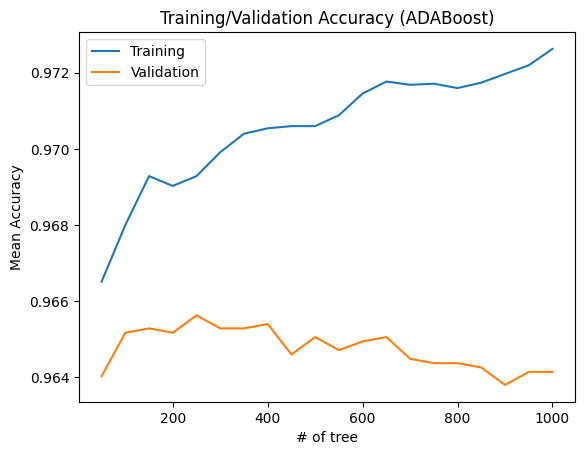

In [ ]:
plt.plot(num_trees, ADA_train_acc, label='Training')
plt.plot(num_trees, ADA_val_acc, label='Validation')
plt.xlabel('# of tree')
plt.ylabel('Mean Accuracy')
plt.title('Training/Validation Accuracy (ADABoost)')
plt.legend()

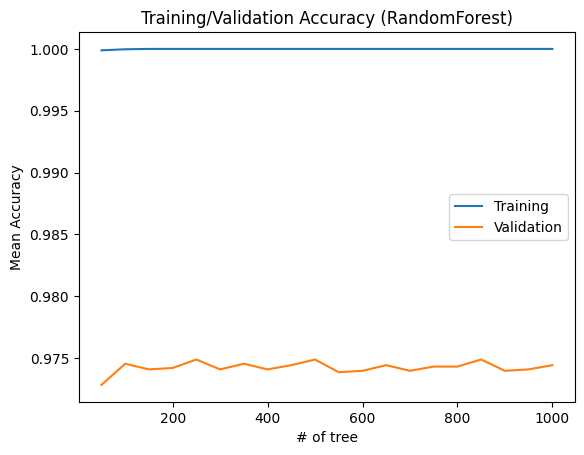

In [ ]:
plt.plot(num_trees, RF_train_acc, label='Training')
plt.plot(num_trees, RF_val_acc, label='Validation')
plt.xlabel('# of tree')
plt.ylabel('Mean Accuracy')
plt.title('Training/Validation Accuracy (RandomForest)')
plt.legend()

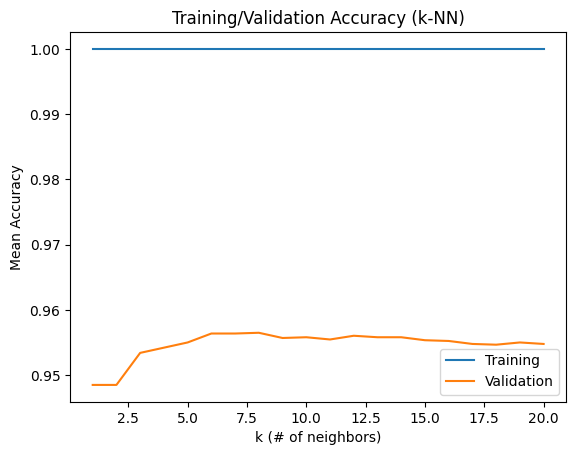

In [ ]:
plt.plot(k_val, NN_train_acc, label='Training')
plt.plot(k_val, NN_val_acc, label='Validation')
plt.xlabel('k (# of neighbors)')
plt.ylabel('Mean Accuracy')
plt.title('Training/Validation Accuracy (k-NN)')
plt.legend()

### **Discussion**



#### **Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s).

I tried a variety of models initially: AdaBoost, Random Forests, k-Nearest Neighbors, Neural Network, and Logistic Regression. However, I narrowed down my options to AdaBoost, Random Forests, and k-Nearest Neighbors. I excluded my neural network and logistic regression models from further testing because they consistently underperformed in terms of training/validation accuracy compared to my ensemble models. So, in the interest of time, I wanted to see how my two ensemble models compared after fine-tuning, and I wanted to employ k-Nearest Neighbors because I just learned about it.

To improve upon each model's initial predictions, I used GridSearchCV to fine-tune the hyperparameters, and I performed some feature engineering. In fact, feature engineering seemed to have a greater effect on my models' predictions than hyperparameter tuning. For my ensemble models, I tried different values for **n_estimators**, **max_depth**, and **min_samples_leaf**, and for k-NN, I varied **n_neighbors**. Though, through testing and reflecting, I decided that I should use the default values for **max_depth** and **min_samples_leaf** and only vary **n_estimators** for my ensemble models.

The above visualiations show how each model's training/validation accuracy changes with their respective hyperparameter. From these plots, I'm inferring how these hyperparameter values may cause my models to overfit and seeing if these trends are consistent with what I have learned. For example, the AdaBoost plot shows validation accuracy tends to drop after **n_estimators** passes 250, while the training accuracy continues increasing. This result is not surprising, as I learned that AdaBoost will eventually overfit as **n_estimators** increases.

#### **Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?

I used many features for my models: **viewed**, **explored**, **nevents**, **ndays_act**, **nplay_video**, **nchapters**, **nforum_posts**, **education**, **male**, **female**, **other**, **interacted**, **duration**, **cs**, **cb**, **er**, **ph1**, and **ph2**.

The features **viewed**, **explored**, **nevents**, **ndays_act**, **nplay_video**, **nchapters**, and **nforum_posts** all come from the original data. The feature **education** is a categorical encoding of **LoE_DI**. The features **male**, **female**, and **other** come from a one-hot encoding of **gender**. The feature **interacted** indicates if **nevents** > 0. The feature **duration** was computed as the difference in days between **start_time_DI** and **last_event_DI**. Finally, the features **cs**, **cb**, **er**, **ph1**, and **ph2** come from a one-hot encoding of **course_id**.

I accounted for missing values by either using an encoding that labels missing values or using a default value, such as 0 or the mean of a column. Additionally, I performed transformations on the features **ndays_act**, **nplay_video**, **nchapters**, and **duration** to account for their large range of values. First I used the PowerTransformer to make the distribution of these feature more normal. Then, I used the StandardScaler to ensure these features had mean 0 and variance 1.

All of these features seemed to be important for my final random forest model, as the random forest models I tested using subsets of these features tended to underperform. However, when I tried using LASSO for feature selection, it seemed like the four most important features were **nevents**, **ndays_act**, **nplay_video**, and **nchapters**

#### **Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?

Yes, there are a number of ethical considerations we should make before acting on this plan. For example, there is an issue of inclusion. By tailoring the course material to the majority group, the educational needs of marginalized groups are not prioritized—meaning the majority group will experience disproportionate benefits. On that note, there is also the potential for my model to exacerbate existing trends of inequality. For instance, even though ethnic and socioeconomic data may not be used to identify the majority group, the decisions made from my model may still indirectly discriminate against marginalized ethnic and socioeconomic groups on the basis of educational background. These marginalized groups may not have the same access to education as other groups, so by tailoring course materials to the majority group, my model effectively restricts marginalized groups' access to education even more. To avoid these ethical pitfalls, a more holistic approach should be taken; rather, than one focused on maximizing profit. One approach may be to implement courses of varying difficulties, allowing students to tailor their education for themselves. Additionally, it would be beneficial to include additional resources in order to even the playing field for students that may not have as much exposure to course materials compared to their peers.